本示例演示了一个最常见的基金择时策略的优化过程，本示例演示了以下内容：
- 创建一个包含均线择时策略的`oeprator`对象，该对象包含的策略采用内置的'DMA‘择时策略
- 通过`qt.configure()`设置相关的环境变量
- 通过对过去10年左右的沪深300指数历史数据，对策略进行参数寻优，最终演示寻优后的结果

## Example Start 示例开始
首先我们导入qteasy模块

同时，为了在线打印图表，使用`matplotlib inline`设置图表打印模式为在线打印

In [1]:
import sys
sys.path.append('../')
import qteasy as qt
%matplotlib inline

### 配置qteasy的基本参数
使用`qt.Context()`创建一个context上下文对象，并进行以下设置：
- 投资回报率的对比数据采用沪深300指数
- 同时设置对比数据的数据类型为“I”

In [2]:
qt.configure(reference_asset = '000300.SH', 
             ref_asset_type = 'I')

- 设置参与投资组合创建的股票池，因为是纯择时策略，因此设置股票池中只有一个沪深300指数，同样设置资产类型为“I” 指数。

In [3]:
qt.configure(asset_pool = '000300.SH',
             asset_type = 'I')

设置投资相关参数：
- moq为0，意味着不存在着必须买卖整数股的条件
- 默认的投资金额为10000元，投入日期为2006年4月6日
- 投资费率是一个Cost对象，以下设置意味着买入费率为千分之一点五，卖出费率为0，没有最低费用的限制，滑点为0

In [4]:
qt.configure(trade_batch_size = 0)
qt.configure(invest_start = '20100105')
qt.configure(invest_end = '20201231')
qt.configure(invest_cash_dates = '20101231')

### 创建Operator对象
使用`qt.Operator()`创建`Operator`对象。
目前`Operator`对象尚不支持动态修改其成员策略，因此需要在创建对象时就指定各个策略成员。
该对象的目的是简单择时，因此`timing_types`设置为一个内置的DMA择时策略，选股策略为`ALL`，表示选择所有股票池内的投资产品，`ricon_type`可以选择`None`即可
这样这个Operator对象就创建完成了，是一个简单DMA择时策略。这个策略有三个参数，通过长、短均线的变化来产生多空仓位信号，一旦多空信号发生变化时，就意味着需要触发交易信号了。

In [5]:
op = qt.Operator(timing_types=['dma'],
                 selecting_types=['all'], ricon_types=['urgent'])

接下来是`Operator`策略参数的设置。
所有的参数设置都可以使用`operator.set_parameter`方法，可以同时传入多个参数
通过设置策略的`opt_tag`可以控制策略是否参与优化，而par_boes参数定义了策略优化时需要用到的参数空间
在此时我们并不知道对于过去15年的沪深300指数来说，最优的DMA择时参数是什么，因此可以输入几个随机的参数，进行一次回测，看看结果如何

In [6]:
op.set_parameter('t-0', opt_tag=1, par_boes=[(10, 250), (10, 250), (10, 250)])
op.set_parameter('r-0', opt_tag=0, par_boes=[(5, 14), (-0.2, -0.01)])
op.set_parameter('s-0', pars=(2,), sample_freq='y')

op.set_parameter('t-0', pars=(35, 50, 25))
op.set_parameter('r-0', pars=(8, -0.1443033))

只要运行`qteasy.run(operator, **config)`就可以开始回测了，其中`**config`是测试环境参数，可以直接以参数的形式传递到`qt.run()`函数中，也可以在run以前通过`qt.configure()`的形式传入，如：

```python
qt.configure(mode=1, 
             print_backtest_log=False,
             parallel=False,
             visual=False,
             hist_data_channel='online',
             hist_dnld_parallel=0)
qt.run(op)
```

为了节省输出空间，我们设置`print_log`参数为`False`，关闭回测过程打印，
运行回测后，回测结果如下：

回测最终资产为19万元，年化收益率只有4.83%，夏普率只有0.0783，收益率低于同期沪深300指数

Progress: [########################################] 2/2. 100.0%  Extracting data local files

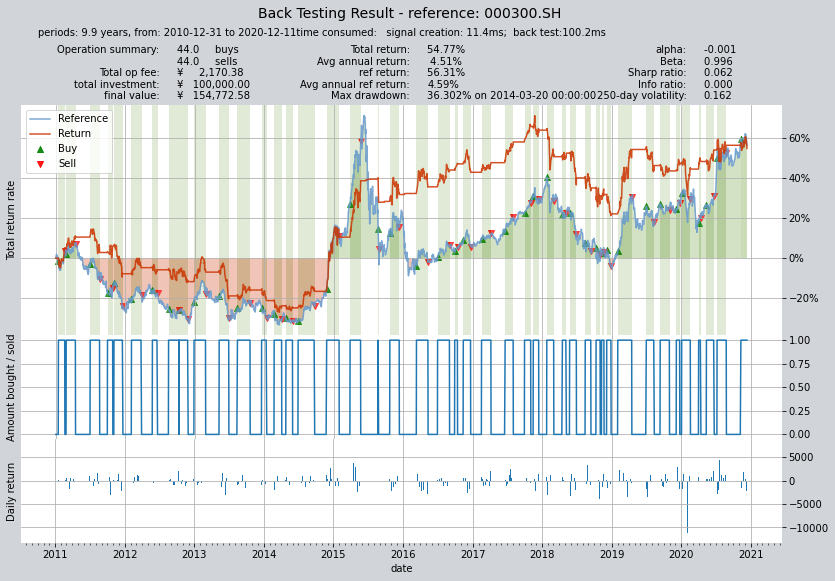

In [7]:
qt.run(op, 
       mode=1, 
       print_backtest_log=False,
       parallel=False,
       visual=True,
       hist_data_channel='local',
       hist_dnld_parallel=0)

### 单择时策略的优化
显然，没有经过优化的参数无法得到理想的回测结果，因此我们需要进行一次优化

通过设置context对象的各个参数，我们可以设置优化方式并控制优化过程：
以下参数的含义分别如下：

- 优化方法设置为1，使用蒙特卡洛优化，对于较大的参数空间有较好的寻优能力
- 输出结果数量设置为30
- 优化过程迭代次数为1000次
- parallel参数设置为True会使用多核处理器的所有核心进行并行计算节省时间

最后开始优化，使用`perfs_dma`和`pars_dma`两个变量来存储优化结果
优化过程中会显示进度条，结束后会显示优化结果

Progress: [########################################] 1000/1000. 100.0%  best performance: 400542.079
Optimization completed, total time consumption: 23"562
Progress: [########################################] 50/50. 100.0%  best performance: 400542.079

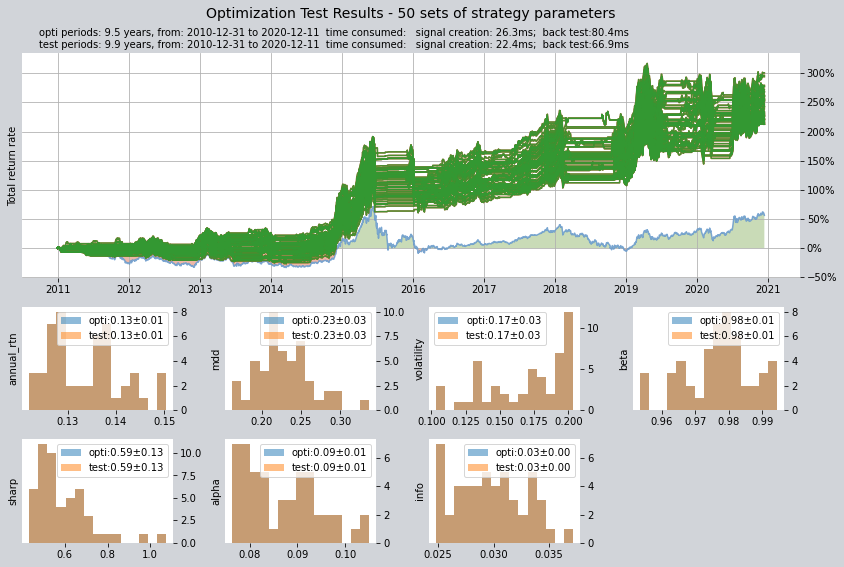

optimization completed, 50 parameters found, they are
[(23, 166, 196), (44, 180, 85), (17, 219, 111), (75, 91, 248), (44, 203, 182), (40, 206, 161), (63, 247, 58), (60, 249, 215), (184, 249, 173), (38, 128, 130), (78, 163, 64), (66, 116, 216), (33, 165, 116), (80, 102, 34), (124, 190, 21), (73, 85, 126), (70, 109, 220), (73, 107, 170), (53, 250, 43), (81, 153, 87), (50, 105, 149), (54, 126, 239), (56, 133, 85), (100, 111, 144), (73, 106, 158), (14, 208, 203), (74, 123, 108), (17, 227, 170), (46, 167, 97), (83, 125, 47), (141, 183, 20), (55, 239, 82), (104, 105, 94), (64, 112, 228), (58, 114, 97), (72, 101, 132), (92, 106, 199), (69, 187, 26), (62, 144, 70), (87, 89, 96), (34, 184, 115), (75, 125, 146), (47, 118, 104), (47, 135, 104), (77, 247, 38), (99, 112, 62), (99, 114, 56), (88, 106, 191), (60, 161, 63), (78, 116, 150)]


In [8]:
pars_dma = qt.run(op, 
                  mode=2,
                  opti_method=1,
                  opti_sample_count=1000,
                  opti_start='20101231',
                  opti_end='20201231',
                  opti_cash_dates='20101231',
                  test_start='20101231',
                  test_end='20201231',
                  test_cash_dates='20101231',
                  parallel=True)
print(f'optimization completed, 50 parameters found, they are\n'
      f'{pars_dma}')

优化结束后，可以看到三十组最佳参数，其中最差的一组也能实现最终资产6万元以上。我们可以手动选取其中最佳的参数，再进行一次回测：

能发现终值从上次回测的1.9万暴涨至12.4万，年化收益18.9%，夏普率也上升到了0.833

Progress: [########################################] 2/2. 100.0%  Extracting data local files

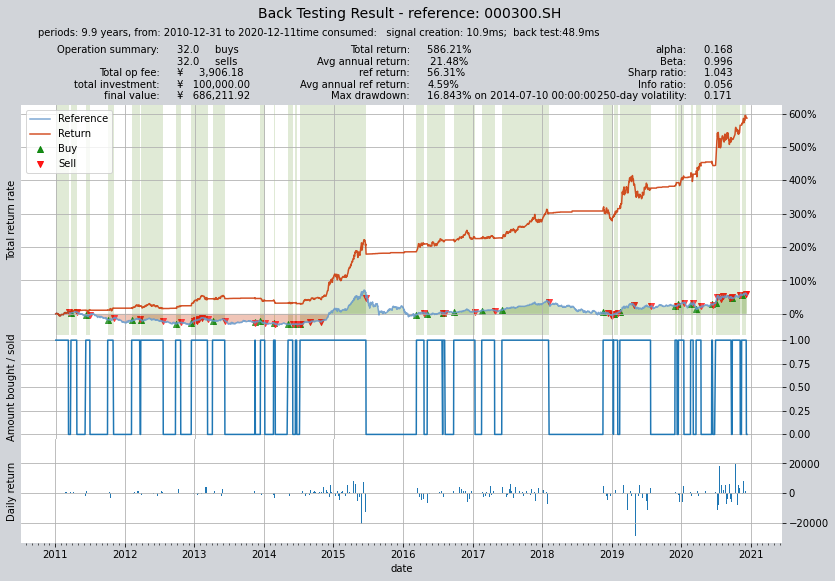

In [14]:
op.set_parameter('t-0', pars=(23, 166, 196))
qt.run(op,
      mode=1, visual=True)

### 择时策略的进一步改进——多重择时
由于择时策略具备一定的随机性，在历史过程中某一个策略并不会总是表现好，而会时而表现好，时而表现差，因此，如果我们同时使用多个参数不同的策略来共同生成择时买卖信号，这样能够形成类似于“委员会”的效果，可能使择时信号在整个时段上都表现较好。

下面，我们就可以创建这样一个多重择时策略，通过多个策略的平均信号或多重信号来进行买卖，看看相对于单一择时策略，能有多少性能提升。

#### 建立多重择时策略

我们可以建立一个包含8个相同的DMA择时策略的operator对象，并对它进行参数设置。

为了在优化过程中充分利用上一步优化的结果，我们可以设置策略的opt_tag参数为2，并将上一次找到的三十组较优参数设置为参数空间，这样下一次优化的时候，将仅从上次优化的结果中选取参数，而忽略其他的参数。

同样设置好基本参数后，可以直接开始优化过程（优化过程忽略）
优化后，我们找到了一组最优参数组，这个参数组中包含了八组DMA参数，需要分别将这八组参数分别赋予operator对象中的八个DMA择时策略

In [12]:
print(f'===============SEARCHING FOR COMBINED PARAMS==================\n'
      f'==============================================================')
op = qt.Operator(timing_types=['dma', 'dma', 'dma', 'dma', 'dma', 'dma', 'dma', 'dma'],
                 selecting_types=['all'], ricon_types=['urgent'])
op.set_parameter('s-0', pars=(2,), sample_freq='y')
op.set_parameter('t-0', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-1', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-2', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-3', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-4', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-5', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-6', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('t-7', opt_tag=2, par_boes=pars_dma, par_types='enum')
op.set_parameter('r-0', opt_tag=0, par_boes=[(5, 14), (-0.2, -0.01)])

op.set_blender('ls', 'none')
op.set_parameter(stg_id='t-0', pars=(163, 233, 24))
op.set_parameter(stg_id='t-1', pars=(192, 222, 249))
op.set_parameter(stg_id='t-2', pars=(96, 179, 29))
op.set_parameter(stg_id='t-3', pars=(41, 167, 218))
op.set_parameter(stg_id='t-4', pars=(84, 152, 219))
op.set_parameter(stg_id='t-5', pars=(192, 222, 249))
op.set_parameter(stg_id='t-6', pars=(119, 135, 187))
op.set_parameter(stg_id='t-7', pars=(163, 233, 24))
op.set_parameter('r-0', pars=(8, -0.1443033))

===============SEARCHING FOR COMBINED PARAMS==================


### 最终结果
设置好优化完成的参数后，进行一次回测，检查结果：

与单个DMA策略的最终结果相比，多重择时策略的提升是巨大的：

资产终值达到了39.7万元，年化收益达到了28.7%，夏普率达到了1.877！
充分说明了多重择时策略的优良性能

Progress: [########################################] 1000/1000. 100.0%  best performance: 573756.062
Optimization completed, total time consumption: 33"849
Progress: [########################################] 50/50. 100.0%  best performance: 573756.062

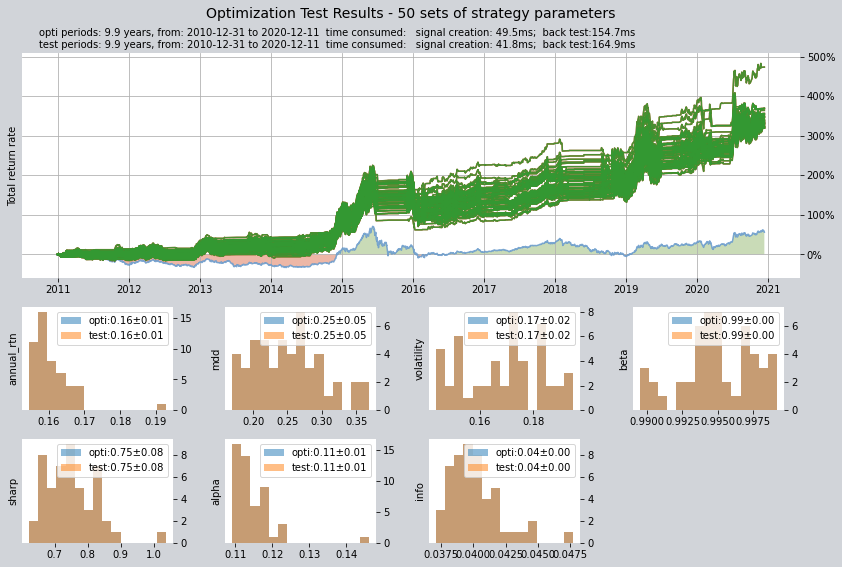

Besr performing parameter: ((78, 116, 150), (54, 126, 239), (81, 153, 87), (184, 249, 173), (99, 114, 56), (92, 106, 199), (77, 247, 38), (34, 184, 115))


In [13]:
pars = qt.run(op, 
              mode=2,
              opti_method = 1,
              opti_sample_count=1000)

print(f'Besr performing parameter: {pars[-1]}')

Progress: [########################################] 1/1. 100.0%  

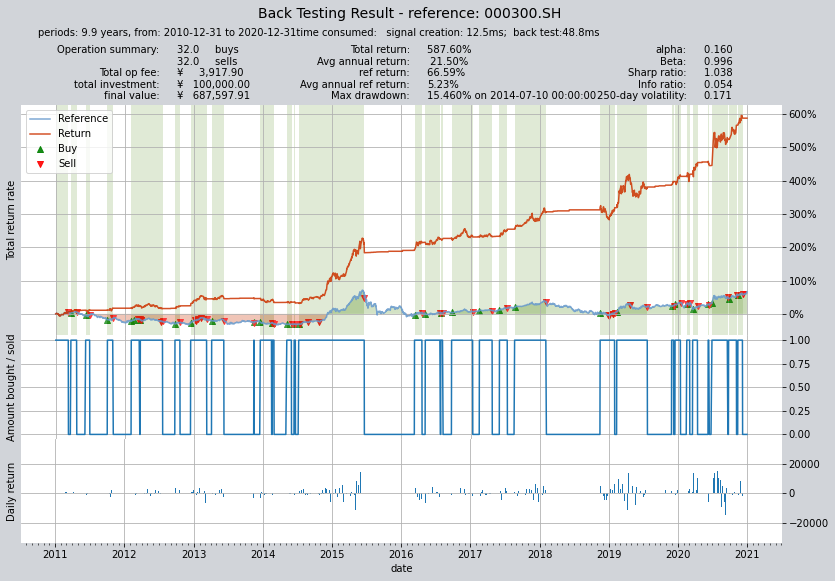

In [28]:
op.set_blender('ls', 'none')
op.set_parameter(stg_id='t-0', pars=(163, 233, 24))
op.set_parameter(stg_id='t-1', pars=(192, 222, 249))
op.set_parameter(stg_id='t-2', pars=(96, 179, 29))
op.set_parameter(stg_id='t-3', pars=(41, 167, 218))
op.set_parameter(stg_id='t-4', pars=(84, 152, 219))
op.set_parameter(stg_id='t-5', pars=(192, 222, 249))
op.set_parameter(stg_id='t-6', pars=(119, 135, 187))
op.set_parameter(stg_id='t-7', pars=(163, 233, 24))
qt.run(op, 
       mode=1,
       opti_sample_count=1000)